# Проект. Прогнозирование тональной окраски комментариев

## Проект для «Викишоп»


## Описание проекта

**Вводные:**
Интернет-магазин «Викишоп» запускает новый сервис, где пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

**Цели:** 
- Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.
- Постройте модель со значением метрики качества F1 не меньше 0.75. 

**Инструкция по выполнению проекта:**
1. Загрузить и подготовить данные.
2. Обучить разные модели.
3. Сделать выводы.

**Описание данных:**
- Данные находятся в файле <code>/datasets/toxic_comments.csv</code>
- Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
# загрузка библиотек и подлючение модулеabsй

import pandas as pd
import numpy as np
import re

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.metrics import f1_score, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from catboost import CatBoostClassifier

from pymystem3 import Mystem
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import nltk

#nltk.download('stopwords')
#nltk.download('punkt')
#nltk.download('wordnet')
#nltk.download('omw-1.4')

from tqdm import notebook, tqdm, tqdm_notebook

import warnings
warnings.filterwarnings('ignore')

from IPython.display import display
%matplotlib inline

SEED = 45

In [2]:
# Грузим данные

#data = pd.read_csv('/datasets/toxic_comments.csv') # В практикуме


data = pd.read_csv('toxic_comments.csv') # Локально


Выведем основную информацию методом <code>.info()</code>

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [4]:
SEED=45
data.sample(5, random_state=SEED)

,Unnamed: 0,text,toxic
103364,103461,"""\n\nAnyone can win against Wikimedia. The ima...",0
61698,61765,You may want to review the notability guidelin...,0
101615,101712,Please Help - Problem with user Blotto Adrift ...,0
34498,34538,. I genuinely think there is room to get to co...,0
63565,63632,I won't. (my only exception to that would be t...,0


Посмотрим на распределение целевого признака <code>toxic</code>

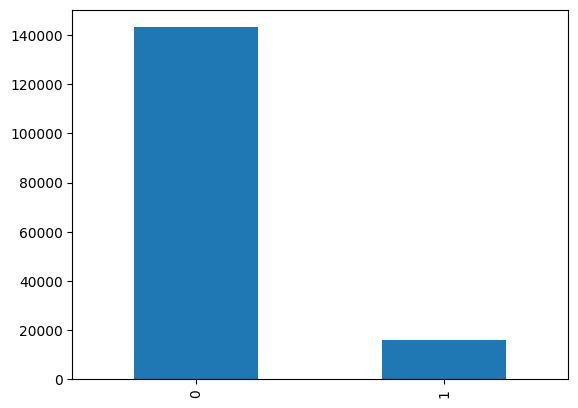

In [5]:
data['toxic'].value_counts().plot(kind='bar');

На графике можно наблюдать огромный дизбалас классов: не токсичных комментариев в 7 раз больше чем токсичных. Это нужно будет учитывать при обучении модели

In [6]:
data.shape

(159292, 3)

In [7]:
data['toxic'].value_counts()

0    143106
1     16186
Name: toxic, dtype: int64

In [8]:
toxic_percent = (sum(data['toxic']) / len(data) * 100)
print(f'Процент токсичных комментариев по отношению ко всем: {toxic_percent:.2f}%')


Процент токсичных комментариев по отношению ко всем: 10.16%


Скопируме датафрейм, чтобы у нас остался исходный вариант

In [9]:
df = data.copy()

### Почистим и лемматизируем текст

In [10]:
df = df.drop('Unnamed: 0', axis=1)

In [11]:
df['text'].head(10)

0    Explanation\nWhy the edits made under my usern...
1    D'aww! He matches this background colour I'm s...
2    Hey man, I'm really not trying to edit war. It...
3    "\nMore\nI can't make any real suggestions on ...
4    You, sir, are my hero. Any chance you remember...
5    "\n\nCongratulations from me as well, use the ...
6         COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK
7    Your vandalism to the Matt Shirvington article...
8    Sorry if the word 'nonsense' was offensive to ...
9    alignment on this subject and which are contra...
Name: text, dtype: object

* Функция для очистки текста:

In [12]:
def clear(text):
    
    text = text.lower()
    text = re.sub(r'(?:\n|\r)',' ', text)
    text = re.sub(r'[^a-zA-Z ]+', '', text).strip()
    
    return text

* Функция для лемматизации

In [13]:
lemmatizer = WordNetLemmatizer()

def lemmatize(text):
    
    word_list = nltk.word_tokenize(text)
    lemmatized = ' '.join([lemmatizer.lemmatize(w) for w in word_list])

    return lemmatized

In [14]:
corpus = df['text'].values

In [15]:
corpus_lemm = [lemmatize(clear(corpus[i])) for i in tqdm(range(len(corpus)))]

100%|██████████| 159292/159292 [01:18<00:00, 2036.14it/s]


* Подгрузим список стопслов

In [16]:
stopwords = set(stopwords.words('english'))

* Разделим выборки на тренировочную и тестовую

In [17]:
X_train, x_test, y_train, y_test = train_test_split(corpus_lemm, 
                                                    df['toxic'], 
                                                    test_size=0.2, 
                                                    random_state=SEED)

In [18]:
print(f'Размер тренировочного корпуса: {len(X_train)}')
print(f'Размер тестового корпуса: {len(x_test)}')


Размер тренировочного корпуса: 127433
Размер тестового корпуса: 31859


* **Проведем векторизацию с помощь TfidfVectorizer()**


In [19]:
tf_idf_vec = TfidfVectorizer(stop_words=stopwords, 
                             min_df=3, 
                             max_df=0.9,
                             use_idf=1, 
                             smooth_idf=1, 
                             sublinear_tf=1)

X_train_vec = tf_idf_vec.fit_transform(X_train)
x_test_vec = tf_idf_vec.transform(x_test) #не делаем fit так как выборка меньше


In [20]:
print(f'Размер тренировочного корпуса: {X_train_vec.shape}')
print(f'Размер тестового корпуса: {x_test_vec.shape}')


Размер тренировочного корпуса: (127433, 41327)
Размер тестового корпуса: (31859, 41327)


## Обучение

Найдем accuracy для константной модели, где все твиты нетоксичны 

In [21]:
base_predictions = pd.Series(data=np.zeros((len(y_train))), index=y_train.index, dtype='int16')
base_accuracy = accuracy_score(y_train, base_predictions)
print(f'Accuracy константной модели {base_accuracy}')

Accuracy константной модели 0.8983073458209412


## Logistic Regression

In [22]:
params = {'C' : np.linspace(10, 20, num=11, endpoint=True),
        'max_iter' : [1000]}
lrm = LogisticRegression()
clf = GridSearchCV(lrm, params, 
                   cv=5, 
                   scoring='f1', 
                   n_jobs=-1,
                   verbose=10)
clf.fit(X_train_vec, y_train)

Fitting 5 folds for each of 11 candidates, totalling 55 fits


GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([10., 11., 12., 13., 14., 15., 16., 17., 18., 19., 20.]),
                         'max_iter': [1000]},
             scoring='f1', verbose=10)

In [23]:
print(f'Наилучший показатель f1 на кросс-валидации: {clf.best_score_:.3f}')
print(f'Параметры регуляризации для лучше модели: {clf.best_params_}')

Наилучший показатель f1 на кросс-валидации: 0.770
Параметры регуляризации для лучше модели: {'C': 14.0, 'max_iter': 1000}


In [24]:
lrm = LogisticRegression(C=14, max_iter=1000)
lrm.fit(X_train_vec, y_train)
predict = lrm.predict(X_train_vec)

**Проверка модели на адекватность** 
- сравним метрику accuracy с константной моделью

In [25]:
accuracy_lr = accuracy_score(y_train, predict)

print(f'Accuracy у логистической регресси {accuracy_lr:.3f}, больше чем у константной модели {base_accuracy:.3f}')

Accuracy у логистической регресси 0.982, больше чем у константной модели 0.898


**Показатель f1 логистической регрессии (0.778) удовлетворяет условиям задания 0.75**

## CatBoostClassifier

Проверим CatBoost без кросс-валидации на тренировочной выборке

In [26]:
scale_pos_weight = round((len(y_train[y_train == 0]) / len(y_train[y_train == 1])), 3)

# Инициализируем модель CatBoostClassifier
CatBoost_clf = CatBoostClassifier(iterations=500, scale_pos_weight=scale_pos_weight, random_state=17)

In [27]:
%%time
CatBoost_clf.fit(X_train_vec, y_train)


Learning rate set to 0.154147
0:	learn: 0.6293267	total: 1.02s	remaining: 8m 28s
1:	learn: 0.5940582	total: 1.68s	remaining: 6m 59s
2:	learn: 0.5740494	total: 2.39s	remaining: 6m 35s
3:	learn: 0.5556488	total: 3.05s	remaining: 6m 17s
4:	learn: 0.5398008	total: 3.71s	remaining: 6m 6s
5:	learn: 0.5311470	total: 4.33s	remaining: 5m 56s
6:	learn: 0.5228986	total: 4.95s	remaining: 5m 48s
7:	learn: 0.5138819	total: 5.57s	remaining: 5m 42s
8:	learn: 0.5067869	total: 6.2s	remaining: 5m 37s
9:	learn: 0.4994101	total: 6.83s	remaining: 5m 34s
10:	learn: 0.4930553	total: 7.44s	remaining: 5m 30s
11:	learn: 0.4871252	total: 8.06s	remaining: 5m 27s
12:	learn: 0.4808606	total: 8.7s	remaining: 5m 25s
13:	learn: 0.4750774	total: 9.31s	remaining: 5m 23s
14:	learn: 0.4698240	total: 9.93s	remaining: 5m 20s
15:	learn: 0.4651461	total: 10.5s	remaining: 5m 18s
16:	learn: 0.4617925	total: 11.2s	remaining: 5m 16s
17:	learn: 0.4585273	total: 11.8s	remaining: 5m 15s
18:	learn: 0.4526655	total: 12.4s	remaining: 5m

157:	learn: 0.2927791	total: 1m 40s	remaining: 3m 37s
158:	learn: 0.2923340	total: 1m 41s	remaining: 3m 36s
159:	learn: 0.2919320	total: 1m 41s	remaining: 3m 35s
160:	learn: 0.2914801	total: 1m 42s	remaining: 3m 35s
161:	learn: 0.2911186	total: 1m 42s	remaining: 3m 34s
162:	learn: 0.2905838	total: 1m 43s	remaining: 3m 33s
163:	learn: 0.2901273	total: 1m 44s	remaining: 3m 33s
164:	learn: 0.2896952	total: 1m 44s	remaining: 3m 32s
165:	learn: 0.2893101	total: 1m 45s	remaining: 3m 31s
166:	learn: 0.2889538	total: 1m 45s	remaining: 3m 31s
167:	learn: 0.2884861	total: 1m 46s	remaining: 3m 30s
168:	learn: 0.2879256	total: 1m 47s	remaining: 3m 29s
169:	learn: 0.2874877	total: 1m 47s	remaining: 3m 28s
170:	learn: 0.2870722	total: 1m 48s	remaining: 3m 28s
171:	learn: 0.2866028	total: 1m 48s	remaining: 3m 27s
172:	learn: 0.2862026	total: 1m 49s	remaining: 3m 26s
173:	learn: 0.2858122	total: 1m 50s	remaining: 3m 26s
174:	learn: 0.2853439	total: 1m 50s	remaining: 3m 25s
175:	learn: 0.2849499	total:

311:	learn: 0.2415633	total: 3m 16s	remaining: 1m 58s
312:	learn: 0.2413176	total: 3m 17s	remaining: 1m 57s
313:	learn: 0.2411477	total: 3m 18s	remaining: 1m 57s
314:	learn: 0.2408492	total: 3m 18s	remaining: 1m 56s
315:	learn: 0.2406363	total: 3m 19s	remaining: 1m 56s
316:	learn: 0.2403943	total: 3m 19s	remaining: 1m 55s
317:	learn: 0.2401836	total: 3m 20s	remaining: 1m 54s
318:	learn: 0.2399493	total: 3m 21s	remaining: 1m 54s
319:	learn: 0.2396754	total: 3m 21s	remaining: 1m 53s
320:	learn: 0.2394274	total: 3m 22s	remaining: 1m 52s
321:	learn: 0.2391720	total: 3m 23s	remaining: 1m 52s
322:	learn: 0.2389451	total: 3m 23s	remaining: 1m 51s
323:	learn: 0.2387254	total: 3m 24s	remaining: 1m 50s
324:	learn: 0.2385774	total: 3m 24s	remaining: 1m 50s
325:	learn: 0.2383637	total: 3m 25s	remaining: 1m 49s
326:	learn: 0.2382419	total: 3m 26s	remaining: 1m 49s
327:	learn: 0.2380062	total: 3m 26s	remaining: 1m 48s
328:	learn: 0.2377720	total: 3m 27s	remaining: 1m 47s
329:	learn: 0.2376011	total:

465:	learn: 0.2111405	total: 4m 52s	remaining: 21.4s
466:	learn: 0.2110003	total: 4m 53s	remaining: 20.7s
467:	learn: 0.2108986	total: 4m 53s	remaining: 20.1s
468:	learn: 0.2108179	total: 4m 54s	remaining: 19.5s
469:	learn: 0.2105540	total: 4m 55s	remaining: 18.8s
470:	learn: 0.2103802	total: 4m 55s	remaining: 18.2s
471:	learn: 0.2101866	total: 4m 56s	remaining: 17.6s
472:	learn: 0.2099838	total: 4m 57s	remaining: 17s
473:	learn: 0.2099060	total: 4m 57s	remaining: 16.3s
474:	learn: 0.2097754	total: 4m 58s	remaining: 15.7s
475:	learn: 0.2096006	total: 4m 58s	remaining: 15.1s
476:	learn: 0.2094943	total: 4m 59s	remaining: 14.4s
477:	learn: 0.2093270	total: 4m 59s	remaining: 13.8s
478:	learn: 0.2092193	total: 5m	remaining: 13.2s
479:	learn: 0.2091415	total: 5m 1s	remaining: 12.5s
480:	learn: 0.2089456	total: 5m 1s	remaining: 11.9s
481:	learn: 0.2088480	total: 5m 2s	remaining: 11.3s
482:	learn: 0.2086950	total: 5m 3s	remaining: 10.7s
483:	learn: 0.2084996	total: 5m 3s	remaining: 10s
484:	l

In [28]:
predict = CatBoost_clf.predict(X_train_vec)
f1_cb = f1_score(y_train, predict)
print(f'Показатель f1 на тренировочной выборке моделия CatBoost (без кросс-валидации): {f1_cb:.3f}')

Показатель f1 на тренировочной выборке моделия CatBoost (без кросс-валидации): 0.811


Получили неплохой результат.

Прогоним на кросс-валидации

In [29]:
# будем проверять результаты на кросс-валидации

# Создаем объект StratifiedKFold
kf = StratifiedKFold(n_splits=5, random_state=17, shuffle=True)

# Инициализируем модель CatBoostClassifier

CatBoost_clf = CatBoostClassifier(iterations=500, scale_pos_weight=scale_pos_weight, random_state=17)

# Списки для сохранения результатов метрик на каждой итерации кросс-валидации
accuracy_scores = []
f1_scores = []

for train_index, test_index in kf.split(X_train_vec, y_train):
    X_train_fold, X_val_fold = X_train_vec[train_index], X_train_vec[test_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[test_index]

    CatBoost_clf.fit(X_train_fold, y_train_fold)

    y_pred = CatBoost_clf.predict(X_val_fold)
    

    accuracy = accuracy_score(y_val_fold, y_pred)
    f1 = f1_score(y_val_fold, y_pred)

    accuracy_scores.append(accuracy)
    f1_scores.append(f1)


Learning rate set to 0.140137
0:	learn: 0.6379720	total: 648ms	remaining: 5m 23s
1:	learn: 0.6000411	total: 1.25s	remaining: 5m 11s
2:	learn: 0.5787151	total: 1.87s	remaining: 5m 9s
3:	learn: 0.5616706	total: 2.51s	remaining: 5m 10s
4:	learn: 0.5455810	total: 3.19s	remaining: 5m 16s
5:	learn: 0.5355555	total: 3.82s	remaining: 5m 14s
6:	learn: 0.5276859	total: 4.42s	remaining: 5m 11s
7:	learn: 0.5181860	total: 5.03s	remaining: 5m 9s
8:	learn: 0.5096884	total: 5.58s	remaining: 5m 4s
9:	learn: 0.5034270	total: 6.13s	remaining: 5m
10:	learn: 0.4972223	total: 6.68s	remaining: 4m 57s
11:	learn: 0.4914212	total: 7.22s	remaining: 4m 53s
12:	learn: 0.4847789	total: 7.76s	remaining: 4m 50s
13:	learn: 0.4808200	total: 8.29s	remaining: 4m 47s
14:	learn: 0.4764214	total: 8.84s	remaining: 4m 45s
15:	learn: 0.4728511	total: 9.39s	remaining: 4m 44s
16:	learn: 0.4685913	total: 9.95s	remaining: 4m 42s
17:	learn: 0.4628949	total: 10.5s	remaining: 4m 41s
18:	learn: 0.4597873	total: 11.1s	remaining: 4m 40s

157:	learn: 0.2974181	total: 1m 29s	remaining: 3m 12s
158:	learn: 0.2970415	total: 1m 29s	remaining: 3m 12s
159:	learn: 0.2964367	total: 1m 30s	remaining: 3m 11s
160:	learn: 0.2958891	total: 1m 30s	remaining: 3m 11s
161:	learn: 0.2954536	total: 1m 31s	remaining: 3m 10s
162:	learn: 0.2949810	total: 1m 31s	remaining: 3m 9s
163:	learn: 0.2945488	total: 1m 32s	remaining: 3m 9s
164:	learn: 0.2940699	total: 1m 32s	remaining: 3m 8s
165:	learn: 0.2935718	total: 1m 33s	remaining: 3m 8s
166:	learn: 0.2932192	total: 1m 34s	remaining: 3m 7s
167:	learn: 0.2928082	total: 1m 34s	remaining: 3m 6s
168:	learn: 0.2923450	total: 1m 35s	remaining: 3m 6s
169:	learn: 0.2919416	total: 1m 35s	remaining: 3m 5s
170:	learn: 0.2913889	total: 1m 36s	remaining: 3m 4s
171:	learn: 0.2909973	total: 1m 36s	remaining: 3m 4s
172:	learn: 0.2904858	total: 1m 37s	remaining: 3m 3s
173:	learn: 0.2901111	total: 1m 37s	remaining: 3m 3s
174:	learn: 0.2894209	total: 1m 38s	remaining: 3m 2s
175:	learn: 0.2888469	total: 1m 38s	remai

310:	learn: 0.2433364	total: 2m 52s	remaining: 1m 44s
311:	learn: 0.2431115	total: 2m 52s	remaining: 1m 44s
312:	learn: 0.2428725	total: 2m 53s	remaining: 1m 43s
313:	learn: 0.2426016	total: 2m 53s	remaining: 1m 42s
314:	learn: 0.2422740	total: 2m 54s	remaining: 1m 42s
315:	learn: 0.2420515	total: 2m 54s	remaining: 1m 41s
316:	learn: 0.2416070	total: 2m 55s	remaining: 1m 41s
317:	learn: 0.2414414	total: 2m 55s	remaining: 1m 40s
318:	learn: 0.2411782	total: 2m 56s	remaining: 1m 40s
319:	learn: 0.2409505	total: 2m 56s	remaining: 1m 39s
320:	learn: 0.2405980	total: 2m 57s	remaining: 1m 39s
321:	learn: 0.2403658	total: 2m 58s	remaining: 1m 38s
322:	learn: 0.2400957	total: 2m 58s	remaining: 1m 37s
323:	learn: 0.2399105	total: 2m 59s	remaining: 1m 37s
324:	learn: 0.2396952	total: 2m 59s	remaining: 1m 36s
325:	learn: 0.2395573	total: 3m	remaining: 1m 36s
326:	learn: 0.2394202	total: 3m	remaining: 1m 35s
327:	learn: 0.2391790	total: 3m 1s	remaining: 1m 35s
328:	learn: 0.2389337	total: 3m 2s	re

465:	learn: 0.2101412	total: 4m 15s	remaining: 18.6s
466:	learn: 0.2100590	total: 4m 15s	remaining: 18.1s
467:	learn: 0.2099319	total: 4m 16s	remaining: 17.5s
468:	learn: 0.2098075	total: 4m 16s	remaining: 17s
469:	learn: 0.2096881	total: 4m 17s	remaining: 16.4s
470:	learn: 0.2096033	total: 4m 17s	remaining: 15.9s
471:	learn: 0.2093792	total: 4m 18s	remaining: 15.3s
472:	learn: 0.2092221	total: 4m 19s	remaining: 14.8s
473:	learn: 0.2091131	total: 4m 19s	remaining: 14.2s
474:	learn: 0.2088952	total: 4m 20s	remaining: 13.7s
475:	learn: 0.2088124	total: 4m 20s	remaining: 13.1s
476:	learn: 0.2087342	total: 4m 21s	remaining: 12.6s
477:	learn: 0.2085461	total: 4m 21s	remaining: 12.1s
478:	learn: 0.2084414	total: 4m 22s	remaining: 11.5s
479:	learn: 0.2083591	total: 4m 23s	remaining: 11s
480:	learn: 0.2081834	total: 4m 23s	remaining: 10.4s
481:	learn: 0.2080552	total: 4m 24s	remaining: 9.86s
482:	learn: 0.2078138	total: 4m 24s	remaining: 9.31s
483:	learn: 0.2075664	total: 4m 25s	remaining: 8.7

123:	learn: 0.3194724	total: 1m 8s	remaining: 3m 26s
124:	learn: 0.3185253	total: 1m 8s	remaining: 3m 25s
125:	learn: 0.3179491	total: 1m 9s	remaining: 3m 24s
126:	learn: 0.3172254	total: 1m 9s	remaining: 3m 24s
127:	learn: 0.3165713	total: 1m 10s	remaining: 3m 23s
128:	learn: 0.3159855	total: 1m 10s	remaining: 3m 23s
129:	learn: 0.3152659	total: 1m 11s	remaining: 3m 22s
130:	learn: 0.3147093	total: 1m 11s	remaining: 3m 21s
131:	learn: 0.3139739	total: 1m 12s	remaining: 3m 21s
132:	learn: 0.3134046	total: 1m 12s	remaining: 3m 20s
133:	learn: 0.3127215	total: 1m 13s	remaining: 3m 19s
134:	learn: 0.3122012	total: 1m 13s	remaining: 3m 19s
135:	learn: 0.3117058	total: 1m 14s	remaining: 3m 18s
136:	learn: 0.3111283	total: 1m 14s	remaining: 3m 18s
137:	learn: 0.3105167	total: 1m 15s	remaining: 3m 17s
138:	learn: 0.3100120	total: 1m 15s	remaining: 3m 16s
139:	learn: 0.3094623	total: 1m 16s	remaining: 3m 16s
140:	learn: 0.3088014	total: 1m 16s	remaining: 3m 15s
141:	learn: 0.3082076	total: 1m 

276:	learn: 0.2529313	total: 2m 30s	remaining: 2m 1s
277:	learn: 0.2527315	total: 2m 31s	remaining: 2m
278:	learn: 0.2524417	total: 2m 31s	remaining: 2m
279:	learn: 0.2517717	total: 2m 32s	remaining: 1m 59s
280:	learn: 0.2516046	total: 2m 32s	remaining: 1m 59s
281:	learn: 0.2512659	total: 2m 33s	remaining: 1m 58s
282:	learn: 0.2510229	total: 2m 33s	remaining: 1m 57s
283:	learn: 0.2506316	total: 2m 34s	remaining: 1m 57s
284:	learn: 0.2504130	total: 2m 34s	remaining: 1m 56s
285:	learn: 0.2501432	total: 2m 35s	remaining: 1m 56s
286:	learn: 0.2498671	total: 2m 35s	remaining: 1m 55s
287:	learn: 0.2497188	total: 2m 36s	remaining: 1m 55s
288:	learn: 0.2493846	total: 2m 37s	remaining: 1m 54s
289:	learn: 0.2491659	total: 2m 37s	remaining: 1m 54s
290:	learn: 0.2488734	total: 2m 38s	remaining: 1m 53s
291:	learn: 0.2485735	total: 2m 38s	remaining: 1m 53s
292:	learn: 0.2482796	total: 2m 39s	remaining: 1m 52s
293:	learn: 0.2481141	total: 2m 39s	remaining: 1m 51s
294:	learn: 0.2478602	total: 2m 40s	r

430:	learn: 0.2179056	total: 3m 52s	remaining: 37.3s
431:	learn: 0.2178138	total: 3m 53s	remaining: 36.7s
432:	learn: 0.2177102	total: 3m 53s	remaining: 36.2s
433:	learn: 0.2176190	total: 3m 54s	remaining: 35.6s
434:	learn: 0.2172370	total: 3m 54s	remaining: 35.1s
435:	learn: 0.2170115	total: 3m 55s	remaining: 34.6s
436:	learn: 0.2168570	total: 3m 56s	remaining: 34s
437:	learn: 0.2167250	total: 3m 56s	remaining: 33.5s
438:	learn: 0.2165501	total: 3m 57s	remaining: 33s
439:	learn: 0.2162989	total: 3m 57s	remaining: 32.4s
440:	learn: 0.2161344	total: 3m 58s	remaining: 31.9s
441:	learn: 0.2160447	total: 3m 58s	remaining: 31.3s
442:	learn: 0.2157861	total: 3m 59s	remaining: 30.8s
443:	learn: 0.2156072	total: 3m 59s	remaining: 30.3s
444:	learn: 0.2153159	total: 4m	remaining: 29.7s
445:	learn: 0.2150594	total: 4m 1s	remaining: 29.2s
446:	learn: 0.2149425	total: 4m 1s	remaining: 28.6s
447:	learn: 0.2148539	total: 4m 2s	remaining: 28.1s
448:	learn: 0.2146989	total: 4m 2s	remaining: 27.6s
449:	

88:	learn: 0.3513411	total: 48.6s	remaining: 3m 44s
89:	learn: 0.3504874	total: 49.1s	remaining: 3m 43s
90:	learn: 0.3495451	total: 49.7s	remaining: 3m 43s
91:	learn: 0.3485766	total: 50.3s	remaining: 3m 43s
92:	learn: 0.3477874	total: 50.9s	remaining: 3m 42s
93:	learn: 0.3458120	total: 51.4s	remaining: 3m 41s
94:	learn: 0.3448870	total: 51.9s	remaining: 3m 41s
95:	learn: 0.3440411	total: 52.4s	remaining: 3m 40s
96:	learn: 0.3427779	total: 53s	remaining: 3m 40s
97:	learn: 0.3416249	total: 53.5s	remaining: 3m 39s
98:	learn: 0.3407525	total: 54.1s	remaining: 3m 39s
99:	learn: 0.3397721	total: 54.6s	remaining: 3m 38s
100:	learn: 0.3390096	total: 55.1s	remaining: 3m 37s
101:	learn: 0.3382495	total: 55.7s	remaining: 3m 37s
102:	learn: 0.3373410	total: 56.2s	remaining: 3m 36s
103:	learn: 0.3365424	total: 56.7s	remaining: 3m 35s
104:	learn: 0.3356616	total: 57.2s	remaining: 3m 35s
105:	learn: 0.3349240	total: 57.7s	remaining: 3m 34s
106:	learn: 0.3341982	total: 58.3s	remaining: 3m 34s
107:	le

242:	learn: 0.2642464	total: 2m 12s	remaining: 2m 19s
243:	learn: 0.2638826	total: 2m 12s	remaining: 2m 19s
244:	learn: 0.2635469	total: 2m 13s	remaining: 2m 18s
245:	learn: 0.2631737	total: 2m 13s	remaining: 2m 18s
246:	learn: 0.2628919	total: 2m 14s	remaining: 2m 17s
247:	learn: 0.2626336	total: 2m 14s	remaining: 2m 16s
248:	learn: 0.2622805	total: 2m 15s	remaining: 2m 16s
249:	learn: 0.2619371	total: 2m 15s	remaining: 2m 15s
250:	learn: 0.2615932	total: 2m 16s	remaining: 2m 15s
251:	learn: 0.2612314	total: 2m 16s	remaining: 2m 14s
252:	learn: 0.2610003	total: 2m 17s	remaining: 2m 14s
253:	learn: 0.2607891	total: 2m 17s	remaining: 2m 13s
254:	learn: 0.2603979	total: 2m 18s	remaining: 2m 13s
255:	learn: 0.2601978	total: 2m 18s	remaining: 2m 12s
256:	learn: 0.2597268	total: 2m 19s	remaining: 2m 11s
257:	learn: 0.2593612	total: 2m 20s	remaining: 2m 11s
258:	learn: 0.2590096	total: 2m 20s	remaining: 2m 10s
259:	learn: 0.2586826	total: 2m 21s	remaining: 2m 10s
260:	learn: 0.2583433	total:

396:	learn: 0.2247219	total: 3m 34s	remaining: 55.7s
397:	learn: 0.2244252	total: 3m 35s	remaining: 55.1s
398:	learn: 0.2242371	total: 3m 35s	remaining: 54.6s
399:	learn: 0.2239535	total: 3m 36s	remaining: 54.1s
400:	learn: 0.2238547	total: 3m 36s	remaining: 53.5s
401:	learn: 0.2237310	total: 3m 37s	remaining: 53s
402:	learn: 0.2234775	total: 3m 37s	remaining: 52.4s
403:	learn: 0.2233810	total: 3m 38s	remaining: 51.9s
404:	learn: 0.2231997	total: 3m 38s	remaining: 51.3s
405:	learn: 0.2229605	total: 3m 39s	remaining: 50.8s
406:	learn: 0.2227360	total: 3m 39s	remaining: 50.2s
407:	learn: 0.2224534	total: 3m 40s	remaining: 49.7s
408:	learn: 0.2221992	total: 3m 41s	remaining: 49.2s
409:	learn: 0.2219975	total: 3m 41s	remaining: 48.6s
410:	learn: 0.2218290	total: 3m 42s	remaining: 48.1s
411:	learn: 0.2216748	total: 3m 42s	remaining: 47.6s
412:	learn: 0.2215059	total: 3m 43s	remaining: 47s
413:	learn: 0.2212284	total: 3m 43s	remaining: 46.5s
414:	learn: 0.2211065	total: 3m 44s	remaining: 46s

53:	learn: 0.3913103	total: 29.8s	remaining: 4m 5s
54:	learn: 0.3901503	total: 30.3s	remaining: 4m 5s
55:	learn: 0.3893020	total: 30.9s	remaining: 4m 5s
56:	learn: 0.3876161	total: 31.5s	remaining: 4m 4s
57:	learn: 0.3865473	total: 32s	remaining: 4m 4s
58:	learn: 0.3845785	total: 32.6s	remaining: 4m 3s
59:	learn: 0.3829694	total: 33.1s	remaining: 4m 2s
60:	learn: 0.3821194	total: 33.6s	remaining: 4m 1s
61:	learn: 0.3808980	total: 34.1s	remaining: 4m 1s
62:	learn: 0.3797140	total: 34.7s	remaining: 4m
63:	learn: 0.3788138	total: 35.2s	remaining: 3m 59s
64:	learn: 0.3778343	total: 35.7s	remaining: 3m 59s
65:	learn: 0.3768296	total: 36.3s	remaining: 3m 58s
66:	learn: 0.3755506	total: 36.8s	remaining: 3m 57s
67:	learn: 0.3743136	total: 37.3s	remaining: 3m 57s
68:	learn: 0.3732503	total: 37.8s	remaining: 3m 56s
69:	learn: 0.3721421	total: 38.4s	remaining: 3m 55s
70:	learn: 0.3710177	total: 38.9s	remaining: 3m 54s
71:	learn: 0.3694091	total: 39.4s	remaining: 3m 54s
72:	learn: 0.3678970	total:

208:	learn: 0.2767581	total: 1m 53s	remaining: 2m 38s
209:	learn: 0.2763418	total: 1m 54s	remaining: 2m 37s
210:	learn: 0.2759921	total: 1m 54s	remaining: 2m 37s
211:	learn: 0.2757282	total: 1m 55s	remaining: 2m 36s
212:	learn: 0.2754191	total: 1m 55s	remaining: 2m 35s
213:	learn: 0.2751072	total: 1m 56s	remaining: 2m 35s
214:	learn: 0.2747242	total: 1m 56s	remaining: 2m 34s
215:	learn: 0.2743123	total: 1m 57s	remaining: 2m 34s
216:	learn: 0.2740122	total: 1m 57s	remaining: 2m 33s
217:	learn: 0.2737821	total: 1m 58s	remaining: 2m 33s
218:	learn: 0.2734264	total: 1m 58s	remaining: 2m 32s
219:	learn: 0.2730892	total: 1m 59s	remaining: 2m 31s
220:	learn: 0.2726456	total: 1m 59s	remaining: 2m 31s
221:	learn: 0.2723663	total: 2m	remaining: 2m 30s
222:	learn: 0.2719886	total: 2m	remaining: 2m 30s
223:	learn: 0.2717604	total: 2m 1s	remaining: 2m 29s
224:	learn: 0.2713948	total: 2m 1s	remaining: 2m 29s
225:	learn: 0.2710757	total: 2m 2s	remaining: 2m 28s
226:	learn: 0.2706432	total: 2m 2s	rema

362:	learn: 0.2320995	total: 3m 17s	remaining: 1m 14s
363:	learn: 0.2319073	total: 3m 17s	remaining: 1m 13s
364:	learn: 0.2316392	total: 3m 18s	remaining: 1m 13s
365:	learn: 0.2313756	total: 3m 18s	remaining: 1m 12s
366:	learn: 0.2311133	total: 3m 19s	remaining: 1m 12s
367:	learn: 0.2308585	total: 3m 19s	remaining: 1m 11s
368:	learn: 0.2307239	total: 3m 20s	remaining: 1m 11s
369:	learn: 0.2305475	total: 3m 20s	remaining: 1m 10s
370:	learn: 0.2303424	total: 3m 21s	remaining: 1m 9s
371:	learn: 0.2301197	total: 3m 21s	remaining: 1m 9s
372:	learn: 0.2300115	total: 3m 22s	remaining: 1m 8s
373:	learn: 0.2297248	total: 3m 22s	remaining: 1m 8s
374:	learn: 0.2295124	total: 3m 23s	remaining: 1m 7s
375:	learn: 0.2292182	total: 3m 23s	remaining: 1m 7s
376:	learn: 0.2290447	total: 3m 24s	remaining: 1m 6s
377:	learn: 0.2285685	total: 3m 25s	remaining: 1m 6s
378:	learn: 0.2283766	total: 3m 25s	remaining: 1m 5s
379:	learn: 0.2280527	total: 3m 26s	remaining: 1m 5s
380:	learn: 0.2277976	total: 3m 26s	re

18:	learn: 0.4602216	total: 10.4s	remaining: 4m 23s
19:	learn: 0.4569547	total: 11s	remaining: 4m 23s
20:	learn: 0.4543895	total: 11.6s	remaining: 4m 25s
21:	learn: 0.4511353	total: 12.2s	remaining: 4m 25s
22:	learn: 0.4484967	total: 12.8s	remaining: 4m 25s
23:	learn: 0.4446195	total: 13.4s	remaining: 4m 25s
24:	learn: 0.4419952	total: 14s	remaining: 4m 26s
25:	learn: 0.4398646	total: 14.6s	remaining: 4m 26s
26:	learn: 0.4381304	total: 15.2s	remaining: 4m 26s
27:	learn: 0.4361774	total: 15.9s	remaining: 4m 27s
28:	learn: 0.4331935	total: 16.5s	remaining: 4m 27s
29:	learn: 0.4310110	total: 17s	remaining: 4m 27s
30:	learn: 0.4287211	total: 17.6s	remaining: 4m 26s
31:	learn: 0.4268274	total: 18.2s	remaining: 4m 25s
32:	learn: 0.4241877	total: 18.7s	remaining: 4m 24s
33:	learn: 0.4222980	total: 19.3s	remaining: 4m 23s
34:	learn: 0.4204468	total: 19.8s	remaining: 4m 23s
35:	learn: 0.4182084	total: 20.4s	remaining: 4m 22s
36:	learn: 0.4156468	total: 20.9s	remaining: 4m 22s
37:	learn: 0.41310

175:	learn: 0.2917000	total: 1m 37s	remaining: 2m 59s
176:	learn: 0.2912726	total: 1m 38s	remaining: 2m 59s
177:	learn: 0.2908481	total: 1m 39s	remaining: 2m 59s
178:	learn: 0.2904665	total: 1m 39s	remaining: 2m 58s
179:	learn: 0.2899603	total: 1m 40s	remaining: 2m 58s
180:	learn: 0.2896010	total: 1m 40s	remaining: 2m 57s
181:	learn: 0.2891464	total: 1m 41s	remaining: 2m 56s
182:	learn: 0.2887206	total: 1m 41s	remaining: 2m 56s
183:	learn: 0.2884434	total: 1m 42s	remaining: 2m 55s
184:	learn: 0.2879551	total: 1m 42s	remaining: 2m 55s
185:	learn: 0.2875870	total: 1m 43s	remaining: 2m 54s
186:	learn: 0.2871478	total: 1m 44s	remaining: 2m 54s
187:	learn: 0.2866969	total: 1m 44s	remaining: 2m 53s
188:	learn: 0.2862774	total: 1m 45s	remaining: 2m 53s
189:	learn: 0.2859396	total: 1m 45s	remaining: 2m 52s
190:	learn: 0.2853521	total: 1m 46s	remaining: 2m 52s
191:	learn: 0.2847349	total: 1m 46s	remaining: 2m 51s
192:	learn: 0.2842094	total: 1m 47s	remaining: 2m 51s
193:	learn: 0.2838514	total:

328:	learn: 0.2402749	total: 3m 7s	remaining: 1m 37s
329:	learn: 0.2400688	total: 3m 7s	remaining: 1m 36s
330:	learn: 0.2399303	total: 3m 8s	remaining: 1m 36s
331:	learn: 0.2397123	total: 3m 8s	remaining: 1m 35s
332:	learn: 0.2393990	total: 3m 9s	remaining: 1m 35s
333:	learn: 0.2391205	total: 3m 10s	remaining: 1m 34s
334:	learn: 0.2389262	total: 3m 10s	remaining: 1m 33s
335:	learn: 0.2386088	total: 3m 11s	remaining: 1m 33s
336:	learn: 0.2384834	total: 3m 11s	remaining: 1m 32s
337:	learn: 0.2382004	total: 3m 12s	remaining: 1m 32s
338:	learn: 0.2379346	total: 3m 13s	remaining: 1m 31s
339:	learn: 0.2377712	total: 3m 13s	remaining: 1m 31s
340:	learn: 0.2376061	total: 3m 14s	remaining: 1m 30s
341:	learn: 0.2372825	total: 3m 14s	remaining: 1m 30s
342:	learn: 0.2371691	total: 3m 15s	remaining: 1m 29s
343:	learn: 0.2370002	total: 3m 15s	remaining: 1m 28s
344:	learn: 0.2367945	total: 3m 16s	remaining: 1m 28s
345:	learn: 0.2366227	total: 3m 17s	remaining: 1m 27s
346:	learn: 0.2364143	total: 3m 1

483:	learn: 0.2095596	total: 4m 39s	remaining: 9.23s
484:	learn: 0.2094083	total: 4m 39s	remaining: 8.65s
485:	learn: 0.2092257	total: 4m 40s	remaining: 8.07s
486:	learn: 0.2091449	total: 4m 40s	remaining: 7.49s
487:	learn: 0.2089323	total: 4m 41s	remaining: 6.92s
488:	learn: 0.2086812	total: 4m 41s	remaining: 6.34s
489:	learn: 0.2084451	total: 4m 42s	remaining: 5.76s
490:	learn: 0.2082909	total: 4m 43s	remaining: 5.19s
491:	learn: 0.2081079	total: 4m 43s	remaining: 4.61s
492:	learn: 0.2079940	total: 4m 44s	remaining: 4.04s
493:	learn: 0.2077894	total: 4m 45s	remaining: 3.46s
494:	learn: 0.2076196	total: 4m 45s	remaining: 2.88s
495:	learn: 0.2074746	total: 4m 46s	remaining: 2.31s
496:	learn: 0.2073917	total: 4m 46s	remaining: 1.73s
497:	learn: 0.2072538	total: 4m 47s	remaining: 1.15s
498:	learn: 0.2070416	total: 4m 48s	remaining: 578ms
499:	learn: 0.2069597	total: 4m 48s	remaining: 0us


In [30]:
# Выведим средние значения метрик на кросс-валидации catboost
print(f"Средняя accuracy: {np.mean(accuracy_scores)}")
print(f"Средний F1-мера: {np.mean(f1_scores)}")
print(f"Максимальная F1-мера: {np.max(f1_scores)}")

Средняя accuracy: 0.9439391765107228
Средний F1-мера: 0.7485440446725611
Максимальная F1-мера: 0.7521968365553603


## LinearSVC

In [31]:

# определяем параметры для перебора
parameters = {'C': np.linspace(1, 31, num = 7, endpoint = True)}

lsvcm = LinearSVC(max_iter = 1000)

clf_lsvc = GridSearchCV(lsvcm, parameters,
                  cv=5,
                  scoring='f1',
                  n_jobs=-1,
                  verbose=2)

In [32]:
clf_lsvc.fit(X_train_vec, y_train)


Fitting 5 folds for each of 7 candidates, totalling 35 fits


GridSearchCV(cv=5, estimator=LinearSVC(), n_jobs=-1,
             param_grid={'C': array([ 1.,  6., 11., 16., 21., 26., 31.])},
             scoring='f1', verbose=2)

In [33]:

print(f"Наилучший показатель f1 на кросс-валидации : {clf_lsvc.best_score_:.3f}")
print(f"Параметр регуляризации для лучшей модели: {clf_lsvc.best_params_}")

Наилучший показатель f1 на кросс-валидации : 0.773
Параметр регуляризации для лучшей модели: {'C': 1.0}


## Выбор лучшей модели

Наилучшие результаты на тренировочной выборке показала модель LinearSVC. Обучим на тестовых данных и узнаем f1

In [36]:
# иницилизируем модель с подобранными параметрами
lsvcm = LinearSVC(C=1, max_iter=1000, verbose=10)


In [37]:
%%time
lsvcm.fit(X_train_vec, y_train)


[LibLinear]CPU times: total: 594 ms
Wall time: 600 ms


LinearSVC(C=1, verbose=10)

In [38]:
predict = lsvcm.predict(x_test_vec)
f1_lsvc = f1_score(y_test, predict)

In [39]:
print(f"Показатель f1 на тестовой выборке: {f1_lsvc:.3f}")

Показатель f1 на тестовой выборке: 0.783


## Вывод

- На первом этапе анализа были:
    - Загружены библиотек и модули 
    - Проведена подготовка данных
        - Очистка данных
        - Лемматизация WordNetLemmatizer
        - Удаление стоп слов
        - Векторизация TfidfVectorizer
   - Были проверены 3 модели на тренировочных данных:
      - Logistic Regression: f1 0.770
      - CatBoostClassifier: f1 0.748
      - LinearSVC: f1 0.773
   - Провера лучшая модель LinearSVC на тестовых данных - результат метрики **f1 0.783** (>0.75)

* Качество моделей практически одинаково. Разница пару %. Максимальный показатель f1 получен для SVM и LogisticRegression
* Кросс-валидация моделей и подбор гиперпараметров проводились с помощью GridSearchCV.
* Проверка на адекватность была проведена для модели LogisticRegression.
       